In [3]:
%load_ext autoreload
%autoreload 2

import networkx as nx
import string
import os
import random
import matplotlib.pyplot as plt
from rn2.utils.utils import save_json, make_dir
from rn2.pruning_models.model2 import parse_network, calculate_q_value, calculate_trace


run = 'v2_100'
selected_folder =  f'../data/{run}/selected'

make_dir(selected_folder)

test_file = os.path.join(selected_folder, 'test.json')
train_file = os.path.join(selected_folder, 'train.json')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


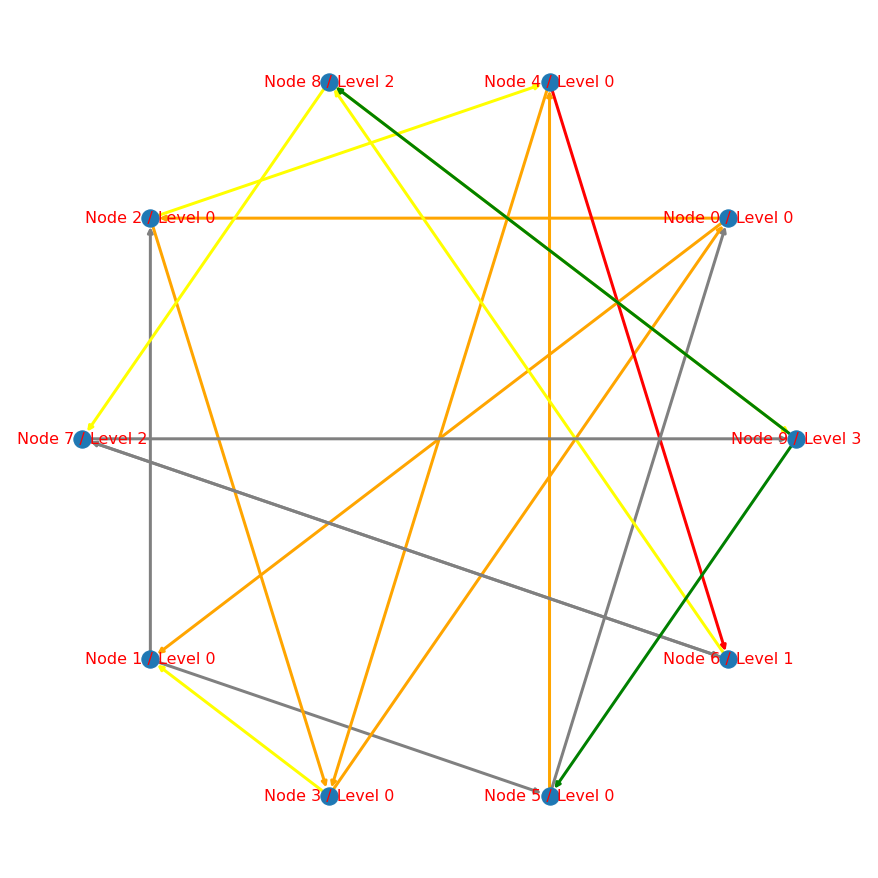

In [8]:

rewards = [-100, -20, 0, 20, 140]
colors = ['red', 'orange', 'gray', 'yellow', 'green']
min_al = 3


from_to = {
    (0,0): [1,2,3],
    (0,1): [0],
    (1,0): [1,2],
    (1,1): [2,3],
    (1,2): [2,3],
    (2,0): [1,2],
    (2,1): [1,2],
    (2,2): [2,3],
    (2,3): [2,3],
    (3,0): [3,4],
    (3,1): [3,4],
    (3,2): [3,4],
    (3,3): [3,4],
}

def add_link(G, a, b):
    a_s = G.nodes[a]['stage']
    b_s = G.nodes[b]['stage']
    reward_idx = random.choice(from_to[(a_s,b_s)])
    G.add_edge(a, b, reward=rewards[reward_idx], reward_idx=reward_idx, color=colors[reward_idx])


def new_node(G, stage):
    idx = len(G)
    name = string.ascii_lowercase[idx%len(string.ascii_lowercase)]+string.ascii_lowercase[idx//len(string.ascii_lowercase)]
    G.add_node(idx, name=name, stage=stage)
    return idx

def filter_node(G, node, current_node):
    if node == current_node:
        return []
    if node in G[current_node]:
        return []
    a_s = G.nodes[current_node]['stage']
    b_s = G.nodes[node]['stage']
    return from_to.get((a_s, b_s), [])


def get_min_incoming(G, nodes):
    in_de = [G.in_degree(n) for n in nodes]
    min_in_de = min(in_de)
    return [n for n, ind in zip(nodes, in_de) if ind == min_in_de]

    
def find_nodes(G, current_node):
    return [
        n
        for n in G.nodes() 
        for _ in filter_node(G, n, current_node)
    ]


def sample_network():
    G = nx.DiGraph()

    node_stages = {
        0: 4,
        1: 1,
        2: 1,
        3: 1
    }

    for i in range(3):
        stage = random.randint(0,3)
        node_stages[stage] += 1

    p_new = 0.0

    for stage, n in node_stages.items():
        for i in range(n):
            new_node(G, stage)

    start_node = 0

    n_edges_per_node = 2

    for i in range(60):
        current_node = start_node
        for j in range(8):
            if len(G.out_edges(current_node)) < n_edges_per_node:
                potential_nodes = find_nodes(G, current_node)
                # if (len(potential_nodes) == 0):
                #     break
                potential_nodes = get_min_incoming(G, potential_nodes)
                next_node = random.choice(potential_nodes)
                add_link(G, current_node, next_node)
                if len(G.edges) == (len(G.nodes) * n_edges_per_node):
                    break
            else:
                next_node = random.choice([e[1] for e in G.out_edges(current_node)])
            current_node = next_node
    return G

G = sample_network()

pos = nx.circular_layout(G)
pos = list(pos.values())
random.shuffle(pos)
pos = {
    n: p for n, p in enumerate(pos)
}

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
labeldict={n: f"Node {n} / Level {d['stage']}" for n, d in G.nodes(data=True)}

plt.figure(figsize=(12,12)) 
nx.draw(G, pos, edge_color=colors, labels=labeldict, font_size=16, font_color="red", width=3)

In [5]:

def parse_node(name, pos_map, id, **kwargs):
    return {
        'id': id,
        'displayName': name,
        **pos_map[id]
    }


def parse_link(source, target, reward, reward_idx, **_):
    return {
        "reward": reward,
        "rewardIdx": reward_idx,
        "sourceId": source,
        "targetId": target
    }


def parse_network_v3(pos_map, *, nodes, links, network_id, **kwargs):
    return {
        'type': 'network',
        'version': 'four-rewards-v3',
        'network_id': network_id,
        'actions': [parse_link(**l) for l in links],
        'nodes': [parse_node(pos_map=pos_map, **n) for n in nodes],
        'starting_node': 0}


def get_max_reward(network):
    edges, rewards = parse_network(network)
    Q = calculate_q_value(edges, rewards, n_steps=8, n_nodes=n_nodes, gamma=0)
    node_trace, reward_trace = calculate_trace(Q, edges, rewards, starting_node=0)
    return reward_trace.sum()


network = nx.json_graph.node_link_data(G)
pos = nx.circular_layout(G)
pos_map = {
    k: {'x': v[0], 'y': v[0]}
    for k, v in pos.items()
}
network = parse_network_v3(**network, pos_map=pos_map, network_id='abc')

In [6]:
networks = []
for i in range(100):
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    network = parse_network_v3(**network, pos_map=pos_map, network_id='abc')
    network['max_reward'] = get_max_reward(network).item()
    networks.append(network)
    save_json(networks, train_file)

networks = []
for i in range(20):
    G = sample_network()
    network = nx.json_graph.node_link_data(G)
    network = parse_network_v3(**network, pos_map=pos_map, network_id='abc')
    network['max_reward'] = get_max_reward(network).item()
    networks.append(network)
    save_json(networks, test_file)    

    

NameError: name 'n_nodes' is not defined

In [ ]:
n_nodes = len(network['nodes'])

edges, rewards = parse_network(network)

print(node_stages)
print(len(edges))


Q = calculate_q_value(edges, rewards, n_steps=8, n_nodes=n_nodes, gamma=0)
node_trace, reward_trace = calculate_trace(Q, edges, rewards, starting_node=0)
print(reward_trace, reward_trace.sum())

Q = calculate_q_value(edges, rewards, n_steps=8, n_nodes=n_nodes, gamma=1.0)
node_trace, reward_trace = calculate_trace(Q, edges, rewards, starting_node=0)
print(reward_trace, reward_trace.sum())

{0: 5, 1: 2, 2: 1, 3: 2}
20
tensor([-100,   20,   20,  140,  140,   20,   20,  140]) tensor(400)
tensor([20, 20, 20, 20, 20, 20, 20, 20]) tensor(160)
